In [1]:
from matplotlib import pyplot as plt
import cv2 as cv
import numpy as np
import tensorflow as tf
import os
import time
import pandas as pd

In [2]:
base_path = "./dataset/dataset_augmented/test/images"
images = os.listdir(base_path)

In [3]:
checkpoint = '__models/07_FasterRCNN_inception_resnet_v2/frozen_inference_graph.pb'

min_confidence = 0.8
detection_graph = tf.Graph()
session = 0

times = []
bboxes = []

with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()  # CHANGED -- instead of tf.GraphDef()

    # CHANGED -- instead of :: with tf.gfile.GFile(self.checkpoint, 'rb') as fid:
    with tf.compat.v2.io.gfile.GFile(checkpoint, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
    # CHANGED -- instead of :: tf.Session(graph=self.detection_graph)
    session = tf.compat.v1.Session(graph=detection_graph)


for idx, img in enumerate(images):
    image = cv.imread(os.path.join(base_path, img))

    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image, axis=0)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

    # Each box represents a part of the image where a particular object was detected.
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

    # Actual detection.
    start = time.time()
    (boxes, scores, classes, num_detections) = session.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded}
    )
    end = time.time()

    times.append(end - start)
    print("[INFO] {:.6f} for image".format(
        end - start) + f" {idx + 1}/{len(images)}")

    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    # faces = []
    im_height, im_width, _ = image.shape
    
    current_boxes = []

    for i in range(boxes.shape[0]):
        if scores[i] >= min_confidence:
            ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
            (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                          ymin * im_height, ymax * im_height)

            x, y, w, h = int(left), int(top), int(
                right - left), int(bottom - top)

            current_boxes.append([x, y, x+w, y+h])
            # faces.append([x, y, w, h, scores[i]])
            # faces.append([x, y, w, h])
            # color = (0, 255, 0)
            # draw_face(image, (x, y, w, h), color)

    bboxes.append(current_boxes)


[INFO] 7.453499 for image 1/790
[INFO] 2.426001 for image 2/790
[INFO] 2.463501 for image 3/790
[INFO] 2.431501 for image 4/790
[INFO] 2.457498 for image 5/790
[INFO] 2.453498 for image 6/790
[INFO] 2.434000 for image 7/790
[INFO] 2.405998 for image 8/790
[INFO] 2.514501 for image 9/790
[INFO] 2.446501 for image 10/790
[INFO] 2.437501 for image 11/790
[INFO] 2.522500 for image 12/790
[INFO] 2.592500 for image 13/790
[INFO] 2.542500 for image 14/790
[INFO] 2.597498 for image 15/790
[INFO] 2.582997 for image 16/790
[INFO] 2.571497 for image 17/790
[INFO] 2.518501 for image 18/790
[INFO] 2.487000 for image 19/790
[INFO] 2.520000 for image 20/790
[INFO] 2.538501 for image 21/790
[INFO] 2.496500 for image 22/790
[INFO] 2.512002 for image 23/790
[INFO] 2.494998 for image 24/790
[INFO] 2.534500 for image 25/790
[INFO] 2.511999 for image 26/790
[INFO] 2.492004 for image 27/790
[INFO] 2.486497 for image 28/790
[INFO] 2.532501 for image 29/790
[INFO] 2.504000 for image 30/790
[INFO] 2.510501 for

In [4]:
import pandas as pd
import numpy as np

p_images = []
p_times = []
p_x1 = []
p_y1 = []
p_x2 = []
p_y2 = []

for p_image, p_time, p_bbox in zip(images, times, bboxes):

    # No Bbox
    if len(p_bbox) == 0:
        p_images.append(p_image)
        p_times.append(p_time)

        p_x1.append(np.NAN)
        p_y1.append(np.NAN)
        p_x2.append(np.NAN)
        p_y2.append(np.NAN)

    # Bbox
    for box in p_bbox:
        # TODO :: Adjust format (x1, y1, ?, ?)
        p_images.append(p_image)
        p_times.append(p_time)

        p_x1.append(box[0])
        p_y1.append(box[1])
        p_x2.append(box[2])
        p_y2.append(box[3])

df = pd.DataFrame(list(zip(p_images, p_times, p_x1, p_y1, p_x2, p_y2)), columns=[
                  "Image", "Time", "X1", "Y1", "X2", "Y2"])
df

,Image,Time,X1,Y1,X2,Y2
0,1001_jpg.rf.b7c44a27e79dbc4de661327ba01c1edd.jpg,7.453499,219,147,461,533
1,1005_jpg.rf.bb3f3203348f9e88224f7467ef52843c.jpg,2.426001,250,154,478,421
2,1005_jpg.rf.bb3f3203348f9e88224f7467ef52843c.jpg,2.426001,143,117,193,178
3,1014_jpg.rf.c539a1eadeef2d13f1bf7d0f7b5c254c.jpg,2.463501,167,138,335,385
4,1061_jpg.rf.44dd02d8bd98efc8deac4f6fbc60ef99.jpg,2.431501,197,55,276,206
...,...,...,...,...,...,...
1216,986_jpg.rf.6f8ff4f13b76e435399fe4d604c285b3.jpg,2.523999,267,137,484,518
1217,987_jpg.rf.dff0e90c55a7621864aee639fd482d98.jpg,2.503499,230,139,295,255
1218,987_jpg.rf.dff0e90c55a7621864aee639fd482d98.jpg,2.503499,320,98,406,215
1219,98_jpg.rf.c929bd3c5be065cfdc29dfe04ff72d87.jpg,2.550000,272,196,369,370


1148_jpg.rf.02b4f42bf07950906637f830582e835b.jpg
184 101 462 386


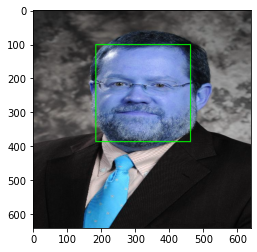

In [5]:
image_names = np.unique(df.Image)
current_entry = image_names[8] # "1_jpg.rf.e3e0a48dd72710db0188e9c100a49f5f.jpg" # 
print(current_entry)

current_df = df[df['Image'] == current_entry]

# Read image from your local file system
testImage = cv.imread(os.path.join(base_path, current_entry))

for df_idx, row in current_df.iterrows():
    if np.isnan(row['X1']):
        continue

    x1 = int(row['X1'])
    y1 = int(row['Y1'])
    x2 = int(row['X2'])
    y2 = int(row['Y2'])

    print(x1, y1, x2, y2)

    cv.rectangle(
        testImage,
        (x1, y1),
        (x2, y2),
        (0, 255, 0),
        2
    )

plt.figure(figsize=(4, 4))
plt.imshow(testImage)
plt.show()


In [6]:
model_name = "FasterRCNN"

folder_path = f"./test_results/{model_name}"
os.mkdir(folder_path)

results_path = f"./test_results/{model_name}.xlsx"


df.to_excel(results_path, index=False)